Install and import Dependencies

In [5]:
import pandas as pd
import numpy as np

In [34]:
import os

In [18]:
import tensorflow as tf
import cv2
import imghdr

C:\Users\shubham.kore\AppData\Local\Temp\ipykernel_30424\456289392.py:3: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## 1. Building Data Pipeline

#### 1.1 Remove dodgy images


In [31]:
data_dir = 'data'

In [32]:
image_exts = ['jpeg','jpg','png','bmp']

In [35]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts :
                print('Image not in exts list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e :
            print('Issue with image {}'.format(image_path))
            

#### 1.2 Load Data

In [36]:
import numpy as np
from matplotlib import pyplot as plt

In [37]:
data = tf.keras.utils.image_dataset_from_directory('data')  #buidling a data pipeline with batches

Found 171 files belonging to 2 classes.


In [38]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [39]:
data_iterator = data.as_numpy_iterator() #accessing data pipeline

In [40]:
batch = data_iterator.next()  #looping through the data

Batch is made of 2 types - images and labels.

- 0 => images
- 1 => labels

In [41]:
batch[0].shape

(32, 256, 256, 3)

In [42]:
#Class 1 = Sad people
# Class 0 = Happy people
batch[1]

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0])

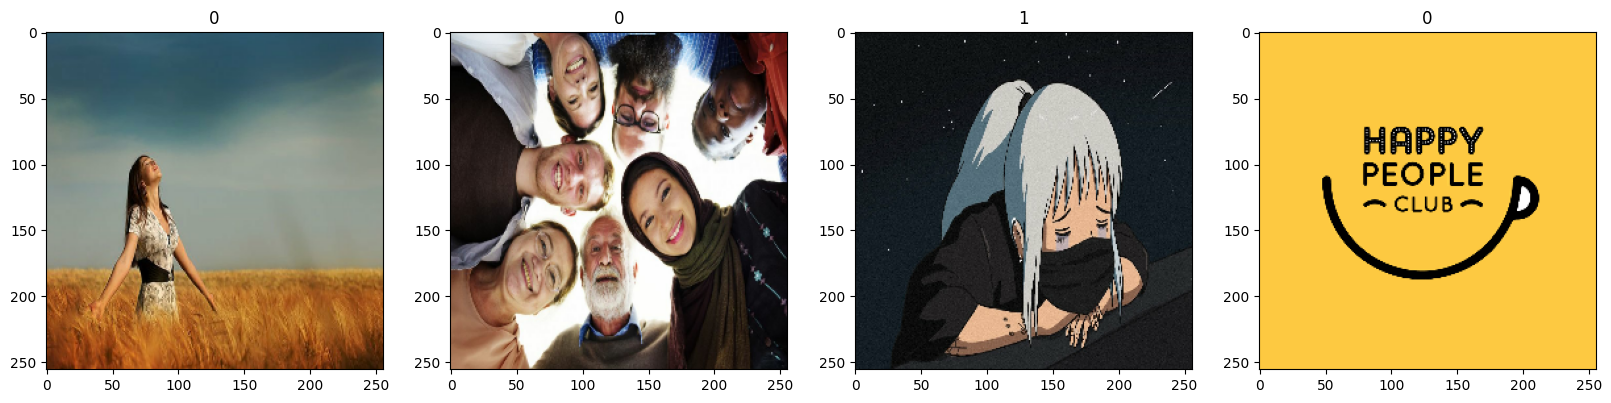

In [43]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 2. Data Preprocessing

#### 2.1 Scale data

In [44]:
data = data.map(lambda x,y : (x/255, y) )  #scaling data in range 0-1

In [45]:
scaled_iterator = data.as_numpy_iterator()

In [46]:
batch = scaled_iterator.next()

In [47]:
batch[0].max()

1.0

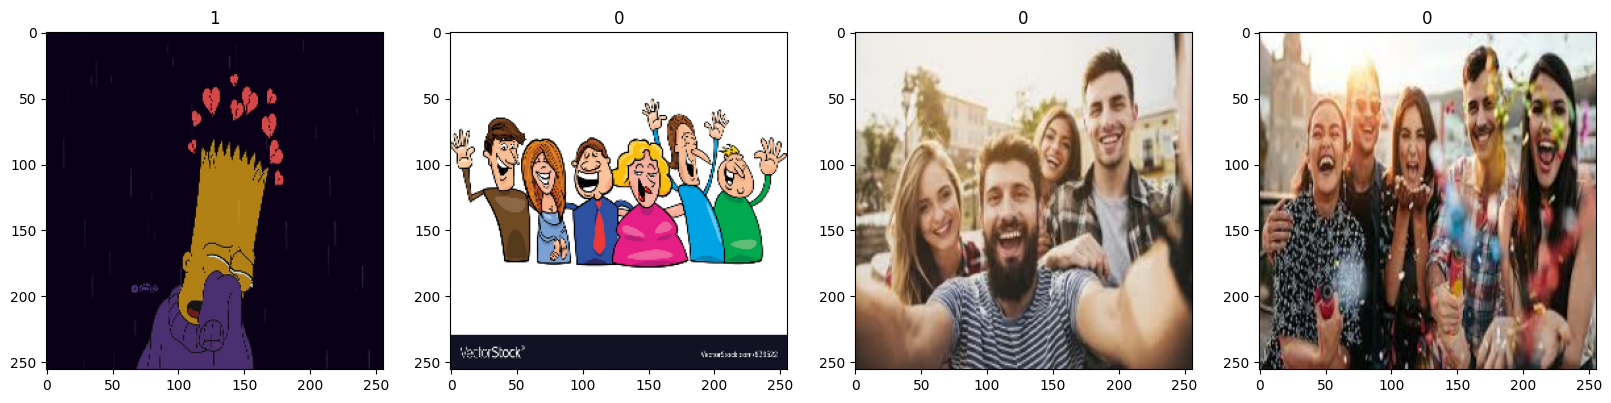

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#### 2.2 Splitting data

In [49]:
len(data)

6

In [69]:
train_size = int(len(data)* 0.7)  #70% data for training
val_size = int(len(data)* 0.2)    #20% data for validation
test_size = int(len(data)* 0.1)+1   #10% data for testing

In [70]:
train_size + val_size + test_size

6

In [71]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 3. Deep Model

#### 3.1 Build Deep learning model

In [89]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [90]:
model = Sequential()

In [91]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

C:\Users\shubham.kore\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [80]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 14400)            

#### 3.2 Training Data

In [93]:
logdir = 'logs'

In [94]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [95]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 643ms/step - accuracy: 0.4354 - loss: 0.7542 - val_accuracy: 0.6562 - val_loss: 0.6809
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.7052 - loss: 0.6595 - val_accuracy: 0.5625 - val_loss: 0.6584
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.6240 - loss: 0.5999 - val_accuracy: 0.7812 - val_loss: 0.5374
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - accuracy: 0.7510 - loss: 0.5989 - val_accuracy: 0.8750 - val_loss: 0.5460
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 451ms/step - accuracy: 0.7958 - loss: 0.4849 - val_accuracy: 0.6562 - val_loss: 0.5544
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 473ms/step - accuracy: 0.7198 - loss: 0.5403 - val_accuracy: 0.8438 - val_loss: 0.4540
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 479ms/step - accuracy: 0.8708 - loss: 0.4140 - val_accuracy: 0.8125 - val_loss: 0.3742
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.8417 - loss: 0.3588 - val_accuracy: 0.9688 - val_loss:

#### 3.3 Plot Performance

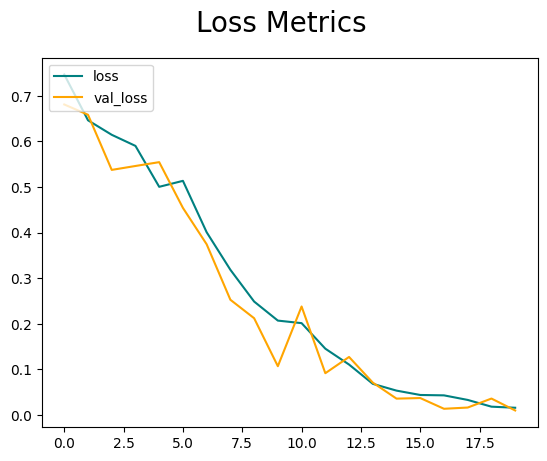

In [99]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss Metrics', fontsize=20)
plt.legend(loc="upper left")
plt.show()

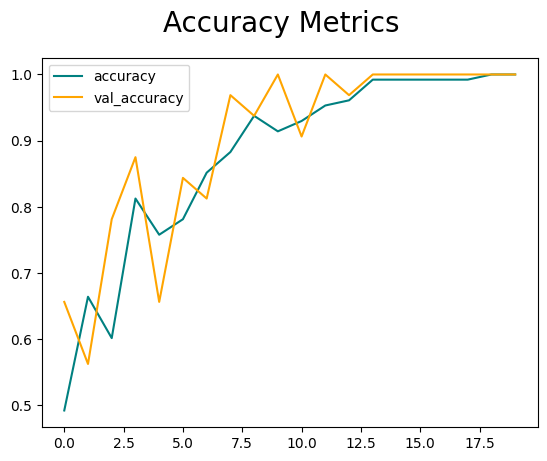

In [100]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy Metrics', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 4. Evaluate Performance

#### 4.1 Evaluate

In [101]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [102]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [103]:
for batch in test.as_numpy_iterator():
    X, y = batch                #true value
    yhat = model.predict(X)     #predicted value
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


In [104]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


#### 4.2 Test

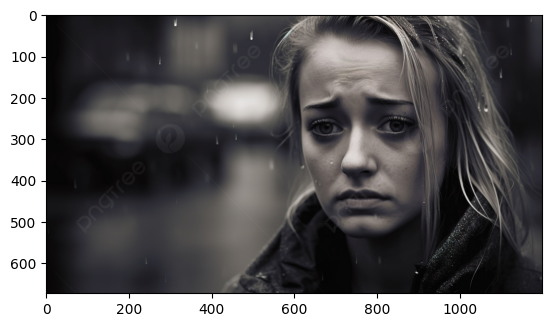

In [117]:
img = cv2.imread('sadtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

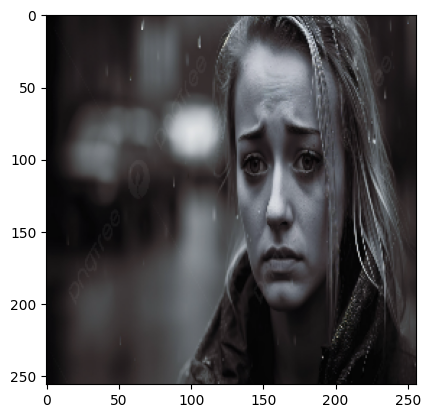

In [118]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [119]:
resize.shape

TensorShape([256, 256, 3])

In [120]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [121]:
yhat

array([[0.9973467]], dtype=float32)

In [122]:
if yhat < 0.5:
    print("The predicted class for the image is Happy.")
else:
    print("The predicted class for the image is Sad.")

The predicted class for the image is Sad.


## 5. Save Model

#### 5.1 Save the model

In [123]:
from tensorflow.keras.models import load_model

In [124]:
model.save(os.path.join('models', 'happysadmodels.h5'))

In [125]:
new_model = load_model(os.path.join('models', 'happysadmodels.h5'))

In [126]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


In [127]:
if yhatnew < 0.5:
    print("The predicted class for the image is Happy.")
else:
    print("The predicted class for the image is Sad.")

The predicted class for the image is Sad.


## 6. Deployment on Streamlit

In [4]:
%%writefile app.py
import streamlit as st
import tensorflow as tf

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation==True)

def load_model():
    model=tf.keras.models.load_model('C:\Users\shubham.kore\OneDrive - Infosys Limited\AI Image Analytics\models\happysadmodels.h5')
    return models

model = load_model()

st.write("""
         # Image Classification
          """)

file = st.file_uploader("Please upload the image", type=["jpg", "png", "jpeg", "bmp"])

import cv2
from PIL import Image, ImageOps
import numpy as np

def import_and_predict(image_data, model):
    
    size = (256,256)
    image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
    img = np.asarray(image)
    img_reshape = img[np.newaxis,...]
    prediction = model.predict(img_reshape)
    
    return prediction

# if file in None:
#     st.text("Please upload an image file")
# else:
#     image - Image.open(file)
#     st.image(image, use_column_width=True)
#     predictions = import_and_predict(image, model)
#     if predictions < 0.5:
#         print("The predicted class for the image is Happy.")
#     else:
#         print("The predicted class for the image is Sad.")

Writing app.py
